In [1]:
import numpy as np


## Linear Equations
$$
Ax = b
$$
### Solution 1:
- Fixed point iteration:

    define $G(x) = Ax - b + x = ( A + I)x - b$, and let $G(x)$ be the x in the next iteration
    
    The iterative process converges if all eigenvalues of (A+I) is within the unit circle. However, this condition is too restrict, which is unlikely to happen in real cases. Therefore, we use Gauss-Jacobi, Gauss-Seidel and other iterative shemes instead.
    
    

### Gauss-Jacobi algorithm

In [2]:
def gauss_jacobi(A,b, x):
    # Extract the diagonal entries
    N = np.diagflat(np.diag(A))
    P = N - A
    return np.linalg.solve(N, b + P.dot(x))

In [3]:

A = np.array([[3,1,2,-2],[1,5,2,-3],[2,3,6,3],[1,1,2,-5]])
x = np.zeros(shape = len(A))
b = np.random.uniform(high = 5,size=len(A))
epsilon = 1e-14
pre_x = np.zeros_like(x)
while True:
    pre_x = x
    x = gauss_jacobi(A,b,x)
    if  ((x - pre_x)**2).sum() < epsilon:
        print('Successfully find solutions:', x)
        break

Successfully find solutions: [-0.9671138   0.12960263  1.1154145  -0.30768481]


### Gauss-Seidel algorithm

In [4]:
def gauss_seidel(A,b, x,w = 1,shuffle = False):
        # Allowing dampening and extrapolating with weight w
        # The sequence of solving x's matters for Gauss-Seidel algorithm, we add a shuffle option
    if shuffle == True:
        values = np.concatenate([A,b.reshape(len(b),-1)],axis=1)
        A = values[:,:-1]
        b = values[:,-1]
    
    # Extract the diagonal entries, lower triangular, and upper triangular
    L = np.tril(A)
    U = A - L
        
    return w * np.linalg.solve(L, b - U.dot(x)) + (1 - w) * x

In [5]:
# Wrap the two linear system solves into a Linear Solver
class LinearSolver:
    
    # We allow direct call methods in the class
    @staticmethod
    def gauss_jacobi(A, b, tol=1e-10):
        x = np.zeros_like(b)
        N = np.diagflat(np.diag(A))
        P = A - N
        
        while True:
            pre_x = x.copy()
            x = np.linalg.solve(N, b - P.dot(pre_x))
            if np.sum((x - pre_x) ** 2) < tol:
                print('Successfully found solutions with Jacobi method:', x)
                break
        
        print("Results for Ax - b =", A.dot(x) - b)
        return x
    
    @staticmethod
    def gauss_seidel(A, b, w=1, shuffle=False, tol=1e-10):
        x = np.zeros_like(b)
        
        if shuffle:
            indices = np.arange(len(b))
            np.random.shuffle(indices)
            A = A[indices]
            b = b[indices]
        
        L = np.tril(A)
        U = A - L
        
        while True:
            pre_x = x.copy()
            x = w * np.linalg.solve(L, b - U.dot(pre_x)) + (1 - w) * pre_x
            if np.sum((x - pre_x) ** 2) < tol:
                print('Successfully found solutions with Gauss-Seidel method:', x)
                break
        
        print("Results for Ax - b =", A.dot(x) - b)
        return x


In [6]:
A = np.array([[1,.5,.3],[.6,1,.1],[.2,.4,1]])
b = np.array([5.,7.,4.])


In [7]:
lin_solver = LinearSolver()
lin_solver.gauss_jacobi(A,b)
lin_solver.gauss_seidel(A,b)

Successfully found solutions with Jacobi method: [1.67155639 5.86510467 1.31964982]
Results for Ax - b = [3.67428675e-06 3.48811842e-06 2.97013887e-06]
Successfully found solutions with Gauss-Seidel method: [1.67155553 5.86510185 1.31964815]
Results for Ax - b = [ 9.00075156e-07 -1.41752707e-08  0.00000000e+00]


array([1.67155553, 5.86510185, 1.31964815])

## Optimization

### Polytope
- Polytope method can be used for any $R^n$ functions, regardless of continuity property
- Polytope can guarantee a solution but cannot guarantee a global minimum (maximum)
- If the objective is rough, Polytope method is advised

In [8]:
def polytope_algorithm(f, simplex, epsilon):
    """
    Description:
    Perform the Polytope Algorithm.
    
    Parameters:
    f (function): The objective function to minimize.
    simplex (numpy array): Initial simplex, an (n+1)x(n) array.
    epsilon (float): Stopping rule parameter.
    
    Returns:
    numpy array: The optimized vertex of the simplex.
    """
    
    n = simplex.shape[0]
    
    while True:
        # Step 1: Reorder the simplex vertices so that f(x^1) >= f(x^2) >= ... >= f(x^{n+1})
        simplex = np.array(sorted(simplex, key=lambda x: f(x), reverse=True))
        # Step 2: Find the least i such that f(x^i) > f(y^i) where y^i is the reflection of x^i
        for i in range(n):
            # We shrink the distance of the reflection
            reflected = 1e-3 * np.mean(np.delete(initial_simplex,i,0)) + simplex[i]
            # The first element that exceeds the function value of the reflected
            if f(simplex[i]) > f(reflected):
                simplex[i] = reflected
                break
        # Step 3: Stopping rule, when the simplex is small enough
        if np.sum(abs(simplex[-1] - simplex[0])) < epsilon:
            return simplex[-1]  # Return the best vertex
        # Step 4: Shrink simplex
        simplex = .5 * simplex[-1] + 0.5 * simplex

# Example usage:
def objective_function(x):
    return np.sum((x - np.array([1.3, 0.8,.3]))**2)  # Example: minimize the sum of squares






In [9]:
# For a 3-dimensional problem, simplex (the convex hull) has three vertex
initial_simplex = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]])


result = polytope_algorithm(objective_function, initial_simplex, epsilon=1e-14)
print("Optimized vertex:", result)

Optimized vertex: [1.21677517 0.71625434 0.46697049]


### Newton Method
- Iteration scheme: $x^{k + 1} = x^k - H^{-1}(x^k) (\nabla f(x^k))^T$

### Quasi-Newton method
#### BFGS

In [2]:
import autograd.numpy as np
from autograd import grad, hessian

In [12]:
import autograd.numpy as np
from autograd import grad, hessian

class BFGS:
    """
    Description: This an example of a BFGS optimizer. 
    For faster convergence, I comment out the delta criterion
    """
    def __init__(self, func, x, epsilon=1e-12,delta = 1e-10):
        self.func = func
        self.x = np.array(x, dtype=float)
        self.epsilon = epsilon
        self.delta = delta
        self.H = np.eye(len(x))
        self.grad_func = grad(func)
        self.hessian_func = hessian(func)
        
    def line_search(self, s, c1=0.6, c2=0.8):
        a = 0.5
        fx = self.func(self.x)
        grads = self.grad_func(self.x)
        
        while True:
            new_x = self.x + a * s
            new_grads = self.grad_func(new_x)
            new_fx = self.func(new_x)
            
            if (new_fx <= fx + c1 * a * (grads.dot(s)) and 
                np.abs(new_grads.dot(s)) < np.abs(c2 * (grads.dot(s)))):
                return a, new_x, new_grads,new_fx
            a *= 2
            if a > 4:
                return 4, new_x, new_grads,new_fx

    def update_hessian(self, z, y):
        H = self.H
        term1 = H - (H.dot(z.reshape(-1, 1)).dot(z.reshape(1, -1)).dot(H)) / (z.dot(H).dot(z))
        term2 = (y.reshape(-1, 1).dot(y.reshape(1, -1))) / (y.dot(z))
        return term1 + term2

    def optimize(self):
        while True:
            fx = self.func(self.x)
            grads = self.grad_func(self.x)
            H = self.hessian_func(self.x)
            s = np.linalg.solve(H, -grads.reshape(-1, 1)).flatten()
            
            lda, x_new, new_grads,new_fx = self.line_search(s)
            z = lda * s
            y = new_grads - grads
            print('Current x: ',self.x)
            self.x = x_new  # Update x to the new position calculated by line_search
            self.H = self.update_hessian(z, y)

            print('Current Function Value= ', fx)
            if (lda < self.delta) or ((z**2).sum() < self.epsilon * (1 + (self.x**2).sum())):
                print('Iteration ends')
#                 if (grads**2).sum() > self.delta * (1 + np.abs(fx)):
#                     print('Not optimum')
#                 else:
#                     print('Reached an optimum')
                print('Success')
                break



In [13]:
# Simple Example
def fun(x):
    x0, x1,x2 = x
    u = x0**(.3) * x1**(.2)*x2**(.5)
    return (u-10)**2

bfgs = BFGS(func= fun, x=np.random.uniform(size=3))
bfgs.optimize()

## You can find a more useful example in the script ``logit_example'' in repo ``DiscreteChoiceModel_2024Summer'', 
## where I use BFGS optimizer to estimate the plain logit model using maximum likelihood estimator. 

Current x:  [0.7436658  0.05336388 0.48186223]
Current Function Value=  93.05598520089283
Current x:  [10.89202182  0.78158844  7.05754383]
Current Function Value=  23.26399630022333
Current x:  [15.96619983  1.14570072 10.34538462]
Current Function Value=  5.815999075055831
Current x:  [18.50328883  1.32775686 11.98930502]
Current Function Value=  1.4539997687639576
Current x:  [19.77183333  1.41878493 12.81126522]
Current Function Value=  0.3634999421909883
Current x:  [20.40610559  1.46429896 13.22224532]
Current Function Value=  0.090874985547746
Current x:  [20.72324171  1.48705598 13.42773537]
Current Function Value=  0.02271874638693677
Current x:  [20.88180977  1.49843449 13.53048039]
Current Function Value=  0.005679686596734192
Current x:  [20.96109381  1.50412374 13.58185291]
Current Function Value=  0.001419921649183682
Current x:  [21.00073582  1.50696837 13.60753916]
Current Function Value=  0.00035498041229595396
Current x:  [21.02055683  1.50839068 13.62038229]
Current 

In [14]:
# Also, we can use BFGS to solve the polytope example
bfgs = BFGS(func= objective_function, x=np.random.uniform(size=3))
bfgs.optimize()


Current x:  [0.39565721 0.83281225 0.45253038]
Current Function Value=  0.8421780340396432
Current x:  [0.84782861 0.81640613 0.37626519]
Current Function Value=  0.21054450850991085
Current x:  [1.0739143  0.80820306 0.33813259]
Current Function Value=  0.05263612712747776
Current x:  [1.18695715 0.80410153 0.3190663 ]
Current Function Value=  0.013159031781869415
Current x:  [1.24347858 0.80205077 0.30953315]
Current Function Value=  0.0032897579454673415
Current x:  [1.27173929 0.80102538 0.30476657]
Current Function Value=  0.0008224394863668289
Current x:  [1.28586964 0.80051269 0.30238329]
Current Function Value=  0.0002056098715917105
Current x:  [1.29293482 0.80025635 0.30119164]
Current Function Value=  5.140246789792596e-05
Current x:  [1.29646741 0.80012817 0.30059582]
Current Function Value=  1.2850616974482306e-05
Current x:  [1.29823371 0.80006409 0.30029791]
Current Function Value=  3.212654243620945e-06
Current x:  [1.29911685 0.80003204 0.30014896]
Current Function Val

## Nonlinear Equations
- General forms for a non-linear system: $f:R^n \rightarrow R^n$

zeros of f: $f(x) = 0$

fixed points of f: $ f(x) = x$

### One-dimension
#### Bisection (linear convergence)

In [15]:
# Without losing generality, we assume a zero point exists between (0,10]
epsilon = 1e-10
def bisect(fun,a = 0.1):
    init_fa = fun(a)
    for potential_b in np.arange(a,4,0.1):
        if fun(potential_b) * init_fa < 1e-10:
            b = potential_b
            break
    else:
        print('No potential b\'s satisfy initialization criterion, choose another b range...')
        return -1
        
    while True:
        interm = (a+b)/2
        fa = fun(a)
        fb = fun(b)
        if fa * fun(interm) <1e-10:
            b = interm
        else:
            a = interm
        print(interm)
        if abs(b - a) < epsilon:
            print('zero point has been found: ', interm)
            break
        

In [16]:
# Example: we consider demand function, D = 2/p + 3; while supply function, S = 4p**3 - 2.
# Therefore, the excess demand function, ED = 2/p + 3 - (4 * exp(p) - 2)

def ed(p):
    return 2/p + 3 - (4*np.exp(p) - 2)

In [17]:
bisect(ed)

0.4
0.55
0.625
0.6625000000000001
0.6812500000000001
0.690625
0.6859375000000001
0.6835937500000001
0.684765625
0.6841796875000001
0.6838867187500002
0.6837402343750001
0.6836669921875
0.6837036132812501
0.6837219238281251
0.6837310791015626
0.6837356567382813
0.6837379455566407
0.6837390899658204
0.6837385177612305
0.6837388038635255
0.683738660812378
0.6837387323379518
0.6837386965751648
0.6837386786937714
0.6837386697530747
0.6837386652827264
0.6837386630475522
0.683738661929965
0.6837386613711716
0.6837386610917748
0.6837386609520764
0.6837386608822271
zero point has been found:  0.6837386608822271


#### Newton's method (one-dimension case)
- Linear approximation: $g(x) = f'(x_k)(x - x_k) + f(x_k)$
- Iteration scheme: $x_{k + 1} = x_k - \frac{f(x_k)}{f'(x_k)}$
- With a hope that the sequence $x_k$ will converge to the zero of $f$ (quadratically convergent)

In [18]:
def newton(fun,x0 = 0.1):
    epsilon = 1e-10
    delta = 1e-10
    x = x0
    grad_fun = grad(fun)
    while True:
        s = fun(x)/ grad_fun(x)
        x -= s
        print(x)
        if abs(s)<epsilon * (1 + abs(x)):
            print('Iteration ends......')
            if abs(fun(x)) < delta:
                print('Solution has been found: ', x)
            else:
                print('No solution has been found')
            break

In [19]:
newton(ed)

0.2006713995766063
0.385396411392974
0.6081124116895442
0.6818824743584165
0.6837387720542631
0.6837394309346968
0.6837394309347784
Iteration ends......
Solution has been found:  0.6837394309347784


In [23]:
# A simple CGE exmple with two consumers and two products
# Following Walras' law, we only need to consider (n-1) market and we normalize p1 + p2 = 1
r = -5
a12 = 1
a21 = 1
a11 = 1024
a22 = 1024
e11 = 12
e22 = 12
e21 = 1
e12 = 1

def fun(p1):
    p2 = 1 - p1
    x12 = (p1 * e11 + p2 * e12)/(p1 * (p1 * a12/p2/a11)**(1/r) + p2)
    x22 = (p1 * e21 + p2 * e22)/(p1 * (p1 * a22/p2/a21)**(1/r) + p2)
    return x12 + x22 - e12 - e22



# Since price has to be non-negative,a.k.a., limited domain, we replace original function with fun_tilde
grad_fun = grad(fun)
def fun_tilde(p1):
    lb = 1e-5
    ub = 1 - 1e-5
    if p1 < lb:
        return fun(lb) + grad_fun(lb) * (p1 - lb) + (p1 - lb)**2 * grad(grad_fun)(lb)/2
    elif p1 > ub:
        return fun(ub) + grad_fun(ub) * (p1 - ub) + (p1 - ub)**2 * grad(grad_fun)(ub)/2
    else:
        return fun(p1)


In [24]:
# This CGE has three equilibria, we can get all of them by setting different initial values
bisect(fun,a = .3)

0.4
0.45
0.475
0.4875
0.49375
0.496875
0.4984375
0.49921875
0.499609375
0.4998046875
0.49990234375
0.499951171875
0.4999755859375
0.49998779296875
0.49998168945312504
0.4999847412109375
0.49998321533203127
0.49998245239257816
0.49998207092285163
0.49998188018798834
0.49998178482055666
0.49998173713684085
0.499981713294983
0.499981701374054
0.4999816954135895
0.49998169243335727
0.4999816909432412
0.4999816901981831
0.49998168982565405
0.49998168963938955
0.4999816895462573
zero point has been found:  0.4999816895462573


In [25]:
newton(fun)

0.11254257722463024
0.1129234593732251
0.11292384712759874
0.11292384712800163
Iteration ends......
Solution has been found:  0.11292384712800163


In [26]:
newton(fun,x0=.9)

0.8889915781252126
0.8871218805566008
0.8870761793372882
0.887076152872008
0.8870761528719988
Iteration ends......
Solution has been found:  0.8870761528719988


In [29]:
# Suffer limited domain issue
newton(fun,x0=0.01)

-0.021535345443671083
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


/var/folders/vq/y8sw0dx95kg8d24dbz5s_kt80000gn/T/ipykernel_98348/3146552554.py:15: RuntimeWarning: invalid value encountered in scalar power
  x12 = (p1 * e11 + p2 * e12)/(p1 * (p1 * a12/p2/a11)**(1/r) + p2)
/var/folders/vq/y8sw0dx95kg8d24dbz5s_kt80000gn/T/ipykernel_98348/3146552554.py:16: RuntimeWarning: invalid value encountered in scalar power
  x22 = (p1 * e21 + p2 * e22)/(p1 * (p1 * a22/p2/a21)**(1/r) + p2)


KeyboardInterrupt: 

In [30]:
# Avoided the limited domain issue, but point x=0 is not a solution
newton(fun_tilde,x0=0.01)

-0.021535345443671083
-0.010743556341296746
-0.005347719412701803
-0.0026499161892814507
-0.001301245024871699
-0.0006273700617935158
-0.00029135161970622077
-0.00012516304547408863
-4.557548683428039e-05
-1.1855598452631391e-05
-2.4123860850689766e-06
-1.534001841631761e-06
-1.526268002423859e-06
-1.5262674027934035e-06
Iteration ends......
Solution has been found:  -1.5262674027934035e-06


### Multivariate nonlinear equation system
- Suppose $f: R^n \rightarrow R^n$ and we want to solve $f(x) = 0$, where 
\begin{align}
    f(x) =0:~ & \begin{bmatrix}
           f^1(x_1,x_2,\dots,x_n)=0 \\
           f^2(x_1,x_2,\dots,x_n)=0 \\
           \vdots \\
            f^n(x_1,x_2,\dots,x_n)=0 \\
         \end{bmatrix}
  \end{align}

#### Gauss-Jacobi Algorithm
- Similar to Gauss-Jacobi algorithm in linear system, update x in the (k+1)-th iteration using one equation
\begin{bmatrix}
           f^1(x^{k+1}_1,x^k_2,\dots,x^k_n)=0 \\
           f^2(x^k_1,x^{k+1}_2,\dots,x^k_n)=0 \\
           \vdots \\
            f^n(x^k_1,x^k_2,\dots,x^{k+1}_n)=0 \\
         \end{bmatrix}

- For each equation, we apply one-dimensional Newton's method
$$
x^{k+1}_i = x^k_i - \frac{f^i(x^k)}{f^i_{x_i}(x_k)}
$$

In [53]:
from autograd import jacobian

In [75]:

def fun(p):
    p1,p2 = p
    x12 = (p1 * e11 + p2 * e12)/(p1 * (p1 * a12/p2/a11)**(1/r) + p2)
    x22 = (p1 * e21 + p2 * e22)/(p1 * (p1 * a22/p2/a21)**(1/r) + p2)
    return np.array([x12 + x22 - e12 - e22,x12 + x22 - e12 - e22])



In [203]:
def fun(params):
    x,y = params
    return np.array([y-np.exp(x), x * (x**2 - 3*y)**2])

In [83]:
def gauss_jacobi(fun, x0 = np.array([0.1,0.1])):
    epsilon = 1e-8
    delta = 1e-5
    jac_func = jacobian(fun)
    x = x0
    while True:
        fx = fun(x)
        jac_inv = 1/np.diag(jac_func(x))
        s = fx * jac_inv
        x -= s
        print(x)
        if (s**2).sum() < epsilon * (1 + (x**2).sum()):
            # This stopping rule is relatively rough, we define more flexible criterion below
            print('Iteration ends......')
            if (fun(x)**2).sum() < delta:
                print('Solution has been found: ', x)
            else:
                print('No solution has been found')
            break

In [84]:
# Slow convergence
gauss_jacobi(fun,x0 = np.array([0.1,0.1]))

[-0.80951626  0.05166667]
[-1.69343051  0.13505276]
[-1.95899952  0.54547753]
[0.90965144 0.91235195]
[0.27702323 0.59408693]
[-0.27263696  0.30983378]
[-0.86569405  0.16730537]
[-1.46806689  0.20855705]
[-1.56275499  0.46348193]
[-0.35104249  0.63877482]
[-0.44363239  0.33992588]
[-0.91390634  0.20276456]
[-1.40820218  0.24058641]
[-1.424541    0.45079877]
[-0.55104394  0.5636189 ]
[-0.57312944  0.33241768]
[-0.98348382  0.22095507]
[-1.39270412  0.27168427]
[-1.29897894  0.45911293]
[-0.61607661  0.51078085]
[-0.67028975  0.31864882]
[-1.04739387  0.2342058 ]
[-1.37985735  0.29994189]
[-1.18778791  0.46730533]
[-0.65511151  0.46879268]
[-0.75251814  0.30592486]
[-1.1032423   0.24734302]
[-1.35776967  0.32652877]
[-1.08838476  0.4705208 ]
[-0.69118558  0.43269063]
[-0.82750019  0.29596823]
[-1.15044532  0.26211021]
[-1.322282    0.35164251]
[-1.00292858  0.4672262 ]
[-0.72915119  0.40125739]
[-0.89721622  0.28923894]
[-1.18778089  0.27878562]
[-1.27342122  0.37453005]
[-0.93520441  0.

[-1.03262454  0.35574477]
[-1.03354132  0.35559129]
[-1.03397317  0.35583026]
[-1.03330124  0.35609855]
[-1.03254749  0.35600118]
[-1.03282119  0.35569298]
[-1.03368697  0.35563309]
[-1.03385571  0.35590134]
[-1.03310145  0.35609361]
[-1.0325615  0.3559299]
[-1.03302136  0.35566216]
[-1.03377371  0.3556866 ]
[-1.03370527  0.35595798]
[-1.0329423   0.35607009]
[-1.03262765  0.35586334]
[-1.03320833  0.35565165]
[-1.03380337  0.35574573]
[-1.03353901  0.35599777]
[-1.03283057  0.3560327 ]
[-1.0327327   0.35580618]
[-1.03336893  0.35565923]
[-1.03378214  0.35580484]
[-1.03337282  0.35602001]
[-1.03276817  0.35598657]
[-1.03286228  0.35576163]
[-1.03349415  0.35568156]
[-1.03371941  0.35585914]
[-1.03322018  0.35602554]
[-1.0327527   0.35593676]
[-1.03300218  0.3557314 ]
[-1.03357915  0.35571462]
[-1.0336265   0.35590495]
[-1.03309143  0.35601643]
[-1.03277834  0.35588787]
[-1.03313952  0.35571578]
[-1.03362312  0.3557541 ]
[-1.03351551  0.35593984]
[-1.03299341  0.35599564]
[-1.03283679  

#### Gauss-Seidel algorithm
- We seperately define each function, which leads to faster calculation speed

In [204]:
def fun1(params):
    x,y = params
    return y-np.exp(x)

def fun2(params):
    x,y = params
    return x * (x**2 - 3*y)**2

In [70]:

def gauss_seidel(funs, x0 = np.array([0.1,0.1])):
    fun1, fun2 = funs
    epsilon = 1e-10
    delta = 1e-10
    x = np.array(x0, dtype=float)
    grad_func1 = grad(fun1)
    grad_func2 = grad(fun2)
    s = np.zeros_like(x)
    past_x = []
    while True:
        print(x)
        past_x.append(x.copy())
        f1x = fun1(x)
        grad1 = grad_func1(x)
        s[0] = f1x/grad1[0]
        x[0] -= s[0]
        grad2 = grad_func2(x)
        f2x = fun2(x)
        s[1] = f2x/grad2[1]
        x[1] -= s[1]
        # estimate rho_hat, the spectral radius of the Jacobian matrix
        # 4-degree lag
        if len(past_x)>5:
            # to aviod accuracy loss, we additionally subtract 1e-5
            b = max((((np.array(past_x[-3:])/np.array(past_x[-4:-1]) - 1e-5)**2)**2).sum(axis=1))
            if (s**2).sum() < epsilon * b:
                print('Iteration ends......')
                if (fun1(x)**2 + fun2(x)**2) < delta:
                    print('Solution has been found: ', x)
                else:
                    print('No solution has been found')
                break

# Find the zero
gauss_seidel([fun1,fun2])


[0.1 0.1]
[-0.80951626  0.15921943]
[-1.45177873  0.43088663]
[-0.61158941  0.27778358]
[-1.09953457  0.34038783]
[-1.07742883  0.3636694 ]
[-1.00928889  0.35161204]
[-1.04458876  0.35766697]
[-1.02801717  0.35497004]
[-1.0356923   0.35626144]
[-1.03208394  0.3556636 ]
[-1.03376853  0.35594469]
[-1.03297961  0.35581349]
[-1.03334852  0.35587494]
[-1.03317589  0.35584621]
[-1.03325664  0.35585965]
[-1.03321886  0.35585336]
[-1.03323654  0.3558563 ]
Iteration ends......
Solution has been found:  [-1.03322827  0.35585493]


$\infty$

### Fixed-point iteration
- For a special class of functions, fixed-point iteration will work well (contract mapping)
- Contract mapping: $f(D) \subset D$ and $\max_{x\in D} ||J(x)||_{\infty} < 1$, where $D\in R^n$ is a closed, bounded, convex set
- Iteration scheme: $x^{k + 1} = f(x^k)$, where

### Newton's method in multivariate equations
- Different from Gauss-Seidel algorithm, we directly extend Newton's method in 1-D into n-D; that is, we replace $f$ with a linear approximation: $f(x) \doteq h(x) = f(x^0) + J(x^0) (x - x^0)$
- Yielding the iterative scheme, and solve the zero of $h(x) \implies x^1 = x^0 - J^{-1}(x^0) f(x^0)$
- Generalize the iterative scheme: $x^{k + 1} = x^k - J^{-1}(x^k)f(x^k)$

In [112]:
def newton(funs,x0):
    x = np.array(x0,dtype=float)
    epsilon = 1e-10
    delta = 1e-8
    jac_func = jacobian(funs)
    while True:
        print(x)
        jacs = jac_func(x)
        fx = fun(x)
        # We do not calculate the inverse of J directly, we solve J*s = f(s) instead.
        s = np.linalg.solve(jacs, fx)
        x -= s
        if (s**2).sum() < epsilon * (1 + (x**2).sum()):
            print('Iteration ends......')
            if (fun(x)**2).sum() < delta:
                print('Solution has been found: ', x)
            else:
                print('No solution has been found')
            break

In [113]:
newton(fun,x0 = [0.1,0.1])

[0.1 0.1]
[-0.59225801  0.3401075 ]
[-1.01959538  0.31672654]
[-1.04719048  0.35078619]
[-1.04033616  0.35332762]
[-1.03680331  0.35458417]
[-1.03502218  0.35521794]
[-1.03412782  0.35553619]
[-1.03367969  0.35569567]
[-1.03345538  0.35577549]
[-1.03334316  0.35581542]
[-1.03328704  0.35583539]
[-1.03325897  0.35584538]
[-1.03324494  0.35585037]
Iteration ends......
Solution has been found:  [-1.03323792  0.35585287]


#### Secand method (Broyden)
- Similar to BFGS, it starts from a rough guess of Jacobian, and update when iterating

In [138]:
def broyden(funs,x0):
    x = np.array(x0,dtype=float)
    epsilon = 1e-10
    delta = 1e-8
    jacs = np.eye(x.shape[0])
    while True:
        print(x)
        fx = funs(x)
        s = -np.linalg.solve(jacs, fx)
        x += s
        y = funs(x) - fx
        jacs += ((y - jacs@s)@s)/(s@s)
        if (s**2).sum() < epsilon * (1 + (x**2).sum()):
            print('Iteration ends......')
            if (funs(x)**2).sum() < delta:
                print('Solution has been found: ', x)
            else:
                print('No solution has been found')
            break


In [179]:
import numpy as np

def broyden(funs, x0, max_iter=100):
    x = np.array(x0, dtype=float)
    epsilon = 1e-10
    delta = 1e-8
    jacs = np.eye(x.shape[0])
    
    for i in range(max_iter):
        print(f"Iteration {i}, x: {x}")
        fx = funs(x)
        s = -np.linalg.solve(jacs, fx)
        x += s
        y = funs(x) - fx
        jacs += np.outer((y - jacs @ s), s) / (s @ s)
        
        if (s**2).sum() < epsilon * (1 + (x**2).sum()):
            print('Iteration ends......')
            if np.linalg.norm(funs(x))**2 < delta:
                print('Solution has been found: ', x)
            else:
                print('No solution has been found')
            break
    else:
        print('Maximum number of iterations reached without convergence.')



In [180]:
# not unique zeros
broyden(fun,x0 = [-.5,0.1])

Iteration 0, x: [-0.5  0.1]
Iteration 1, x: [0.00653066 0.10125   ]
Iteration 2, x: [-1.14342974  0.10201517]
Iteration 3, x: [-1.51685162  1.62239617]
Iteration 4, x: [-2.18146611 -0.62192011]
Iteration 5, x: [-0.07198591  1.31577293]
Iteration 6, x: [0.30240439 1.19534192]
Iteration 7, x: [0.14295534 1.19340126]
Iteration 8, x: [0.1194998  1.14319068]
Iteration 9, x: [-4.68322889e-04  9.79708162e-01]
Iteration 10, x: [-0.01381478  0.98154264]
Iteration 11, x: [-0.00784028  0.99077733]
Iteration 12, x: [9.37047346e-04 1.00099001e+00]
Iteration 13, x: [-4.08134099e-05  9.99958960e-01]
Iteration 14, x: [3.74389546e-07 1.00000047e+00]
Iteration ends......
Solution has been found:  [2.07652529e-08 1.00000002e+00]


In [181]:
broyden(fun,x0 = [-.9,0.4])

Iteration 0, x: [-0.9  0.4]
Iteration 1, x: [-0.89343034  0.53689   ]
Iteration 2, x: [-0.85419909  0.35563086]
Iteration 3, x: [-0.71307698  0.30470336]
Iteration 4, x: [-1.00300303  0.37923343]
Iteration 5, x: [-1.00235488  0.37211813]
Iteration 6, x: [-1.00895129  0.36597955]
Iteration 7, x: [-1.01719188  0.36189716]
Iteration 8, x: [-1.02314176  0.35950428]
Iteration 9, x: [-1.02697614  0.35809505]
Iteration 10, x: [-1.02937529  0.357229  ]
Iteration 11, x: [-1.03085086  0.35670299]
Iteration 12, x: [-1.0317623   0.35637796]
Iteration 13, x: [-1.0323241   0.35617811]
Iteration 14, x: [-1.03267067  0.35605472]
Iteration 15, x: [-1.03288489  0.3559785 ]
Iteration 16, x: [-1.03301702  0.35593148]
Iteration 17, x: [-1.03309879  0.35590238]
Iteration 18, x: [-1.03314923  0.35588443]
Iteration 19, x: [-1.03318045  0.35587332]
Iteration 20, x: [-1.03319971  0.35586647]
Iteration ends......
Solution has been found:  [-1.03321163  0.35586222]


### Remarks
- Outside the special case of contraction mapping, none of these nonlinear methods is globally convergent

#### Enhancing convergence with Powell's Hybrid method
- Define $SSR(x) \equiv \sum_{i = 1}^n f^i(x)^2$
- The solutions to $SSR(x)$ to the nonlinear system are exactly the global solutions to the minimization problem of SSR


In [219]:
def powell_fun(x,fun):
    return (fun(x)**2).sum()
# For simplicity, I directly import the minimzer in scipy.optimize
import scipy.optimize as opt    
# As is shown, the solution is the same, that is, Powell's hybrid method works.
print("Estimates yielding Powell\'s hybrid method: ",opt.minimize(powell_fun,x0 = [-0.1,0.1],args = fun,method='BFGS').x)

Estimates yielding Powell's hybrid method:  [-1.03590721  0.35490613]


## Approximation Methods

#### Rational Approximation
- The k-th degree Taylor series approximation is the degree $k$ polynomial that matches $f$ at $x_0$ up to the k-th derivative


In [281]:
import autograd.numpy as np

In [345]:
def f(x):
    return x**(-.5)

In [351]:
x = np.arange(0.01,4,.01)

In [356]:
y = f(x)

In [352]:
import matplotlib.pyplot as plt
%matplotlib inline

In [353]:
# 3-degree Taylor expansion
def taylor(f,x,x0):
    grad_f1 = grad(f)
    grad_f2 = grad(grad_f1)
    grad_f3 = grad(grad_f2)
    return f(x) + grad_f1(x) * (x - x0) + grad_f2(x) /2 * (x - x0)**2 + grad_f3(x) /6 * (x - x0)**3


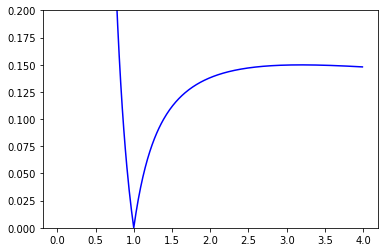

In [366]:
y_hat = []
for i in x:
    y_hat.append(taylor(f,i,1))
_, ax = plt.subplots()
# The radius of convergence is bounded above ||x_0 - z||, where z is the singularity.
# That is, not accurate for |x - 1| > (1-0) AKA x>2 or x<0
plt.plot(x,abs(y-y_hat),axes=ax,color='blue')
ax.set_ybound([0.,0.2])